# Gender in the Text: Pronouns & Nearby Verbs

**Goal.** Compare how often male- vs female-coded pronouns occur and which **verbs** tend to appear near them.  
**Why it matters.** Pronoun balance shows who occupies narrative space; verbs near pronouns hint at **agency** (who acts, decides, feels).  
**Method (quick):** tokenize → count pronouns per 10k words → collect ±3-word windows around pronouns and list the most frequent **neighboring verbs**; discuss limitations and how POS tagging would improve precision.


In [11]:
from pathlib import Path
import re
from collections import Counter
import math

import pandas as pd
import matplotlib.pyplot as plt

# Folders
DATA_DIR = Path("../../data") if Path(".").name != "applied-NLP-project" else Path("data")
RESULTS_DIR = Path("../../results") if Path(".").name != "applied-NLP-project" else Path("results")
OUT_DIR = RESULTS_DIR / "adverbs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

BOOKS = {
    "War_and_Peace": DATA_DIR / "War_and_Peace.txt",
    "Anna_Karenina": DATA_DIR / "Anna_Karenina.txt",
}

# sanity check: make sure texts exist and aren't tiny HTML error pages
for name, p in BOOKS.items():
    if not p.exists() or p.stat().st_size < 100000:
        raise FileNotFoundError(f"{name} missing/invalid: {p}")


In [12]:
def load_text(path: Path) -> str:
    return path.read_text(encoding="utf-8", errors="ignore")

def normalize(text: str) -> str:
    text = text.lower()
    text = text.replace("—"," ").replace("–"," ").replace("’","'")
    text = re.sub(r"[^a-z']+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return text.split()

def per_10k(c, n): 
    return (c / n) * 10_000 if n else 0.0

STOP = {
    "the","and","to","of","a","i","in","that","was","he","his","it","you","is","for","with",
    "as","on","her","at","be","not","but","had","she","they","him","by","from","this","have",
    "or","my","we","all","so","one","were","me","are","said","an","which","their","there",
    "what","when","then","out","up","would","if","your","has","into","about","could","over",
    "them","no","more","who","do","did","than","been","any","only","very","some","because",
    "its","those","our","down","again","after"
}


In [13]:
# Heuristic: words ending with -ly (common for adverbs)
def is_adverb_heuristic(tok: str) -> bool:
    # filter some frequent false positives
    bad = {"family","reply","supply","belly","italy","holy","lily","silly","july","nelly"}
    return tok.endswith("ly") and tok not in bad

# Small curated adverb list to catch non-ly adverbs/common ones
CURATED_ADVERBS = {
    "very","so","too","quite","rather","almost","already","always","never","often","seldom",
    "sometimes","usually","hardly","nearly","again","away","here","there","now","then",
    "truly","really","fully","merely","exactly","simply","clearly","slowly","quickly",
    "suddenly","carefully","closely","gently","softly","roughly","merely","likely",
    "immediately","particularly","gradually","equally","literally","especially","possibly",
    "probably","certainly"
}

def is_adverb(tok: str) -> bool:
    return is_adverb_heuristic(tok) or tok in CURATED_ADVERBS


In [14]:
tokens = {}
totals = {}
adv_tokens = {}
adv_counts = {}
adv_totals = {}

for name, path in BOOKS.items():
    norm = normalize(load_text(path))
    toks = tokenize(norm)
    tokens[name] = toks
    totals[name] = len(toks)

    advs = [t for t in toks if is_adverb(t)]
    adv_tokens[name] = advs
    adv_counts[name] = Counter(advs)
    adv_totals[name] = len(advs)

summary_df = pd.DataFrame({
    "book": list(BOOKS.keys()),
    "total_tokens": [totals[b] for b in BOOKS.keys()],
    "adverb_tokens": [adv_totals[b] for b in BOOKS.keys()],
    "adverbs_per_10k_tokens": [per_10k(adv_totals[b], totals[b]) for b in BOOKS.keys()]
})
summary_df


,book,total_tokens,adverb_tokens,adverbs_per_10k_tokens
0,War_and_Peace,580109,20076,346.072893
1,Anna_Karenina,352018,13727,389.951650


In [15]:
# unified vocab of adverbs across both books
vocab_adv = set().union(*[set(adv_counts[b].keys()) for b in BOOKS.keys()])

rows = []
for w in vocab_adv:
    row = {"adverb": w}
    for b in BOOKS.keys():
        c = adv_counts[b][w]
        row[f"{b}_count"] = c
        row[f"{b}_per10k"] = per_10k(c, totals[b])  # rate per entire text length
    rows.append(row)

adverbs_df = pd.DataFrame(rows).sort_values(
    ["War_and_Peace_count", "Anna_Karenina_count"], ascending=False
)
adverbs_df.head(12)


,adverb,War_and_Peace_count,War_and_Peace_per10k,Anna_Karenina_count,Anna_Karenina_per10k
589,so,1902,32.786942,1550,44.031839
451,there,1478,25.477971,1019,28.947383
620,now,1332,22.961202,873,24.799868
441,only,1300,22.409582,652,18.521780
692,then,941,16.221089,516,14.658341
391,very,804,13.859464,651,18.493372
602,again,709,12.221841,444,12.612991
662,away,617,10.635932,430,12.215284
812,here,484,8.343260,344,9.772228
585,always,464,7.998497,344,9.772228


In [16]:
def log_likelihood(k1, n1, k2, n2):
    if k1 == 0 and k2 == 0: 
        return 0.0
    p = (k1 + k2) / (n1 + n2)
    e1, e2 = n1 * p, n2 * p
    def t(o, e): 
        return 0.0 if o == 0 or e == 0 else o * math.log(o / e)
    g2 = 2 * (t(k1, e1) + t(k2, e2))
    # sign by relative rate
    return g2 if (k1/n1 if n1 else 0) >= (k2/n2 if n2 else 0) else -g2

rows = []
for _, r in adverbs_df.iterrows():
    k1 = int(r["War_and_Peace_count"])
    k2 = int(r["Anna_Karenina_count"])
    if k1 + k2 >= 5:  # ignore super-rare adverbs
        g2 = log_likelihood(k1, totals["War_and_Peace"], k2, totals["Anna_Karenina"])
        rows.append({
            "adverb": r["adverb"],
            "G2_signed": g2,
            "War_and_Peace_per10k": r["War_and_Peace_per10k"],
            "Anna_Karenina_per10k": r["Anna_Karenina_per10k"]
        })
adv_keyness = pd.DataFrame(rows).sort_values("G2_signed", ascending=False)
adv_keyness.head(15)


,adverb,G2_signed,War_and_Peace_per10k,Anna_Karenina_per10k
14,evidently,154.578793,6.033349,1.107898
34,ily,71.137958,1.292860,0.000000
52,orderly,33.187858,0.741240,0.028408
36,silently,30.852843,1.154955,0.198853
76,tely,29.403689,0.534382,0.000000
33,involuntarily,25.355295,1.310099,0.340892
48,formerly,23.544638,0.792954,0.113631
49,previously,23.544638,0.792954,0.113631
40,nearly,23.511415,0.982574,0.198853
10,suddenly,22.517024,7.446876,4.914521


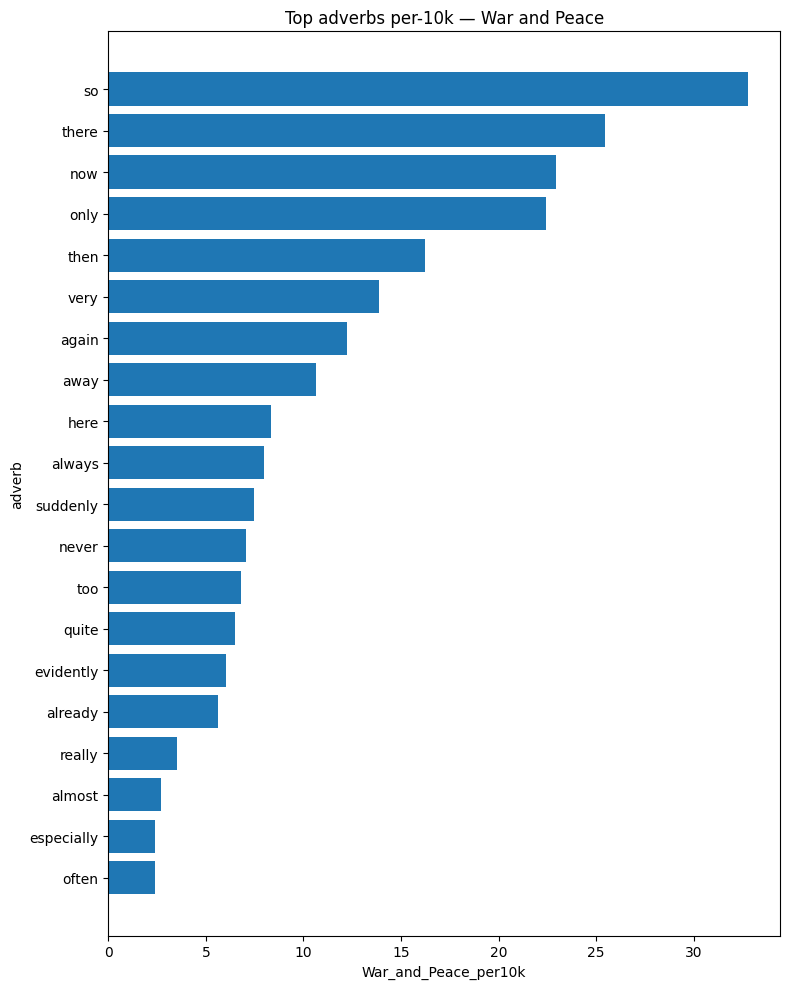

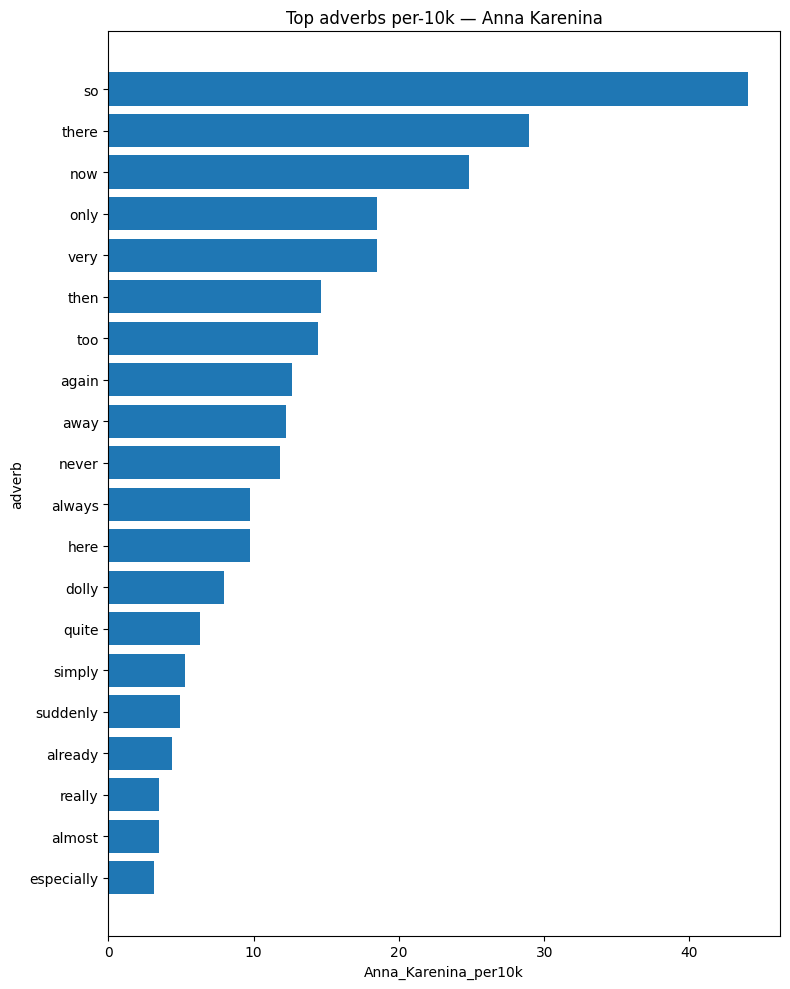

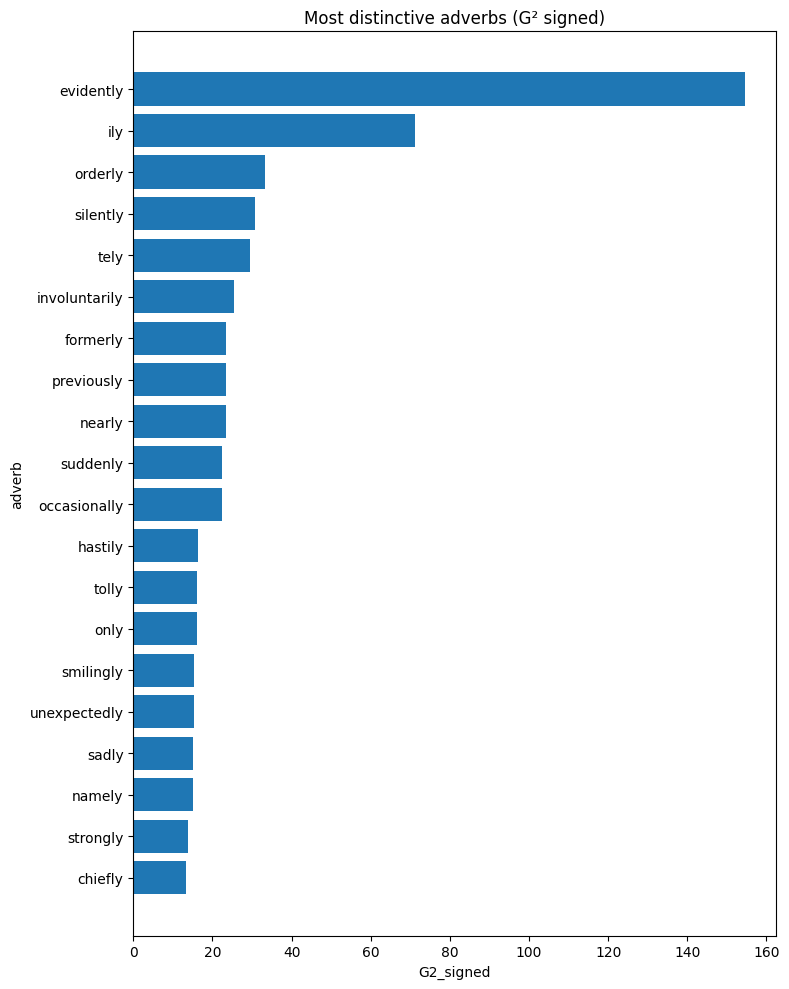

In [17]:
def plot_top(df, col, book, k=20, title=None):
    top = df.sort_values(col, ascending=False).head(k)
    plt.figure(figsize=(8,10))
    plt.barh(top["adverb"][::-1], top[col][::-1])
    plt.title(title or f"Top {k} adverbs by {col.split('_')[-1]} in {book.replace('_',' ')}")
    plt.xlabel(col)
    plt.ylabel("adverb")
    plt.tight_layout()
    plt.show()

# Top adverbs per book by per-10k
plot_top(adverbs_df, "War_and_Peace_per10k", "War_and_Peace", 20, "Top adverbs per-10k — War and Peace")
plot_top(adverbs_df, "Anna_Karenina_per10k", "Anna_Karenina", 20, "Top adverbs per-10k — Anna Karenina")

# Distinctive adverbs (positive → W&P, negative → A.K.)
plot_top(adv_keyness.rename(columns={"adverb":"adverb"}), "G2_signed", "War_and_Peace", 20, "Most distinctive adverbs (G² signed)")


In [18]:
summary_df.to_csv(OUT_DIR / "adverbs_summary_per_book.csv", index=False)
adverbs_df.to_csv(OUT_DIR / "adverbs_counts_per10k.csv", index=False)
adv_keyness.to_csv(OUT_DIR / "adverbs_distinctiveness_g2.csv", index=False)
print("Saved files in:", OUT_DIR.as_posix())


Saved files in: ../../results/adverbs
